In [1]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


# Training a ConvNet PyTorch

In this notebook, you'll learn how to use the powerful PyTorch framework to specify a conv net architecture and train it on the CIFAR-100 dataset.

In [0]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torch.utils.data import sampler

import torchvision.datasets as dset
import torchvision.transforms as T

import numpy as np

import timeit

# data
import tensorflow as tf

# Load Datasets

We load the CIFAR-100 dataset. This might take a couple minutes the first time you do it, but the files should stay cached after that.

In [5]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar100.load_data()

cifar100_train = [(torch.Tensor(x), y) for x,y in zip(x_train.transpose(0,3,1,2), y_train.flatten())]
cifar100_test = [(torch.Tensor(x), y) for x,y in zip(x_test.transpose(0,3,1,2), y_test.flatten())]

169009152/169001437 [==============================] - 160s 1us/step


# DataLoader


In [0]:
class ChunkSampler(sampler.Sampler):
    """Samples elements sequentially from some offset. 
    Arguments:
        num_samples: # of desired datapoints
        start: offset where we should start selecting from
    """
    def __init__(self, num_samples, start = 0):
        self.num_samples = num_samples
        self.start = start

    def __iter__(self):
        return iter(range(self.start, self.start + self.num_samples))

    def __len__(self):
        return self.num_samples

In [0]:
'''
DataLoader(dataset, batch_size=1, shuffle=False, 
           sampler=None, batch_sampler=None, num_workers=0,
           collate_fn=<function default_collate at 0x1110b2730>, pin_memory=False,
           drop_last=False, timeout=0, worker_init_fn=None)


Data loader. Combines a dataset and a sampler, and provides
single- or multi-process iterators over the dataset.

Arguments:
    dataset (Dataset): dataset from which to load the data.
    batch_size (int, optional): how many samples per batch to load
        (default: 1).
    shuffle (bool, optional): set to ``True`` to have the data reshuffled
        at every epoch (default: False).
    sampler (Sampler, optional): defines the strategy to draw samples from
        the dataset. If specified, ``shuffle`` must be False.
    batch_sampler (Sampler, optional): like sampler, but returns a batch of
        indices at a time. Mutually exclusive with batch_size, shuffle,
        sampler, and drop_last.
    num_workers (int, optional): how many subprocesses to use for data
        loading. 0 means that the data will be loaded in the main process.
        (default: 0)
    collate_fn (callable, optional): merges a list of samples to form a mini-batch.
    pin_memory (bool, optional): If ``True``, the data loader will copy tensors
        into CUDA pinned memory before returning them.
    drop_last (bool, optional): set to ``True`` to drop the last incomplete batch,
        if the dataset size is not divisible by the batch size. If ``False`` and
        the size of dataset is not divisible by the batch size, then the last batch
        will be smaller. (default: False)
    timeout (numeric, optional): if positive, the timeout value for collecting a batch
        from workers. Should always be non-negative. (default: 0)
    worker_init_fn (callable, optional): If not None, this will be called on each
        worker subprocess with the worker id (an int in ``[0, num_workers - 1]``) as
        input, after seeding and before data loading. (default: None)

.. note:: By default, each worker will have its PyTorch seed set to
          ``base_seed + worker_id``, where ``base_seed`` is a long generated
          by main process using its RNG. However, seeds for other libraies
          may be duplicated upon initializing workers (w.g., NumPy), causing
          each worker to return identical random numbers. (See
          :ref:`dataloader-workers-random-seed` section in FAQ.) You may
          use ``torch.initial_seed()`` to access the PyTorch seed for each
          worker in :attr:`worker_init_fn`, and use it to set other seeds
          before data loading.


'''    
NUM_TRAIN = 40000
NUM_VAL = 10000

loader_train = DataLoader(cifar100_train, batch_size=64, sampler=ChunkSampler(NUM_TRAIN, 0))
loader_val = DataLoader(cifar100_train, batch_size=64, sampler=ChunkSampler(NUM_VAL, NUM_TRAIN))
loader_test = DataLoader(cifar100_test, batch_size=64)

# model reuse - reset parameters

In [0]:
# This is a little utility that we'll use to reset the model
# if we want to re-initialize all our parameters
def reset(m):
    if hasattr(m, 'reset_parameters'):
        m.reset_parameters()

# GPU

In [12]:
torch.cuda.is_available()

True

In [0]:
gpu_dtype = torch.cuda.FloatTensor

# Train & check accuracy

In [0]:
def train(model, loss_fn, optimizer, num_epochs, dtype=gpu_dtype):
    for epoch in range(num_epochs):
        print('Starting epoch %d / %d' % (epoch + 1, num_epochs))
        model.train()
        total_loss = 0
        for t, (x, y) in enumerate(loader_train):
            x_var = Variable(x.type(gpu_dtype))
            y_var = Variable(y.type(gpu_dtype).long())

            scores = model(x_var)
            
            loss = loss_fn(scores, y_var)
            total_loss += loss.data

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        if (epoch+1) % 10 == 0:
            print(epoch+1)
            print('loss = %.4f' % (total_loss/(t+1)))
            print('train :')
            check_accuracy(model, loader_val, gpu_dtype)

def check_accuracy(model, loader, dtype=gpu_dtype):
    num_correct = 0
    num_samples = 0
    model.eval() # Put the model in test mode (the opposite of model.train(), essentially)
    with torch.no_grad():
        for x, y in loader:
            x_var = Variable(x.type(dtype))

            scores = model(x_var)
            _, preds = scores.data.cpu().max(1)
            num_correct += (preds == y).sum()
            num_samples += preds.size(0)
    acc = float(num_correct) / num_samples
    print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))
    

In [16]:
from google.colab import files
uploaded = files.upload()

#for fn in uploaded.keys():
#  print('User uploaded file "{name}" with length {length} bytes'.format(
#      name=fn, length=len(uploaded[fn])))

Saving vgg.png to vgg.png


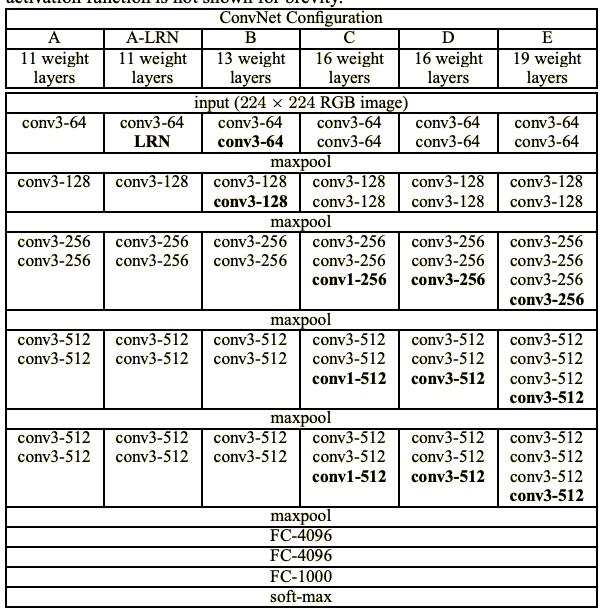

In [22]:
from IPython.display import Image, display
display(Image('vgg.png'))

# Make your own model

In [0]:
class VGG(nn.Module):
    def __init__(self, features, num_classes=100, dtype = gpu_dtype):
        super().__init__()
        self.dtype = dtype
        self.features = features
        self.classifier = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(256, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(256, num_classes)
        ).type(dtype)

    
    def forward(self, x):
        output = self.features(x)
        output = output.view(output.size()[0], -1)
        output = self.classifier(output)
    
        return output

In [0]:
cfg = {
    'A' : [64,     'M', 128,      'M', 256, 256,           'M', 512, 512,           'M', 512, 512,           'M'],
    'B' : [64, 64, 'M', 128, 128, 'M', 256, 256,           'M', 512, 512,           'M', 512, 512,           'M'],
    'D' : [64, 64, 'M', 128, 128, 'M', 256, 256, 256,      'M', 512, 512, 512,      'M', 512, 512, 512,      'M'],
    'E' : [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M']
}

def make_layers(cfg, batch_norm=False, dtype=gpu_dtype):
    layers = []
    in_channels = 3
    for v in cfg:
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        else:
            conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
            else:
                layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = v
    return nn.Sequential(*layers).type(dtype)


def vgg11_bn():
    return VGG(make_layers(cfg['A'], batch_norm=True))

def vgg13_bn():
    return VGG(make_layers(cfg['B'], batch_norm=True))

def vgg16_bn():
    return VGG(make_layers(cfg['D'], batch_norm=True))

def vgg19_bn():
    return VGG(make_layers(cfg['E'], batch_norm=True))



In [0]:

vgg11 = vgg11_bn()
loss_fn = nn.CrossEntropyLoss().type(gpu_dtype)
optimizer = optim.Adam(vgg11.parameters(),lr=1e-4)

In [96]:
vgg11

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace)
    (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace)
    (14): MaxPool2d(kernel_size=2, stride=

# Train and check

In [99]:
torch.cuda.random.manual_seed(12345)
vgg11.apply(reset)
train(vgg11, loss_fn, optimizer, 50, dtype)

Starting epoch 1 / 100
Starting epoch 2 / 100
Starting epoch 3 / 100
Starting epoch 4 / 100
Starting epoch 5 / 100
Starting epoch 6 / 100
Starting epoch 7 / 100
Starting epoch 8 / 100
Starting epoch 9 / 100
Starting epoch 10 / 100
10
loss = 1.4302
train :
Got 3672 / 10000 correct (36.72)
Starting epoch 11 / 100
Starting epoch 12 / 100
Starting epoch 13 / 100
Starting epoch 14 / 100
Starting epoch 15 / 100
Starting epoch 16 / 100
Starting epoch 17 / 100
Starting epoch 18 / 100
Starting epoch 19 / 100
Starting epoch 20 / 100
20
loss = 0.3640
train :
Got 3776 / 10000 correct (37.76)
Starting epoch 21 / 100
Starting epoch 22 / 100
Starting epoch 23 / 100
Starting epoch 24 / 100
Starting epoch 25 / 100
Starting epoch 26 / 100
Starting epoch 27 / 100
Starting epoch 28 / 100
Starting epoch 29 / 100
Starting epoch 30 / 100
30
loss = 0.1854
train :
Got 3974 / 10000 correct (39.74)
Starting epoch 31 / 100
Starting epoch 32 / 100
Starting epoch 33 / 100
Starting epoch 34 / 100
Starting epoch 35 /

In [100]:
check_accuracy(vgg11, loader_test, dtype)

Got 4460 / 10000 correct (44.60)
